In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [0]:
! tar -xf '/content/gdrive/My Drive/Colab Notebooks/selfie.tar.gz'

In [0]:
import tensorflow as tf
import keras
from keras.applications import resnet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import numpy as np
import random
import cv2
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import io
from skimage import util
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import numpy as np
%matplotlib inline
import matplotlib.image as mpimg

### Vizualization

In [0]:
import pandas as pd

In [0]:
data_frame = pd.read_csv("Selfie-dataset/selfie_dataset.txt",sep=" ")
data_frame.columns = ['image_name','popularity_score','partial_faces','is_female','baby','child','teenager','youth','middle_age','senior','white','black','asian','ovaal_face','round_face','heart_face','smiling','mouth_open','frowning','wearing_glasses','wearing_sunglasses','wearing_lipstick','tongue_out','duck_face','black_hair','blond_hair','brown_hair','red_hair','curly_hair','straight_hair','braid_hair','showing_cellphone','using_earphone','using_mirror','braces','wearing_hat','harsh_lighting','dim_lighting']

In [0]:
good_selfie_df = data_frame[['image_name','is_female','baby','child','teenager','youth','middle_age','senior']]


In [0]:
good_selfie_df.head(10)

,image_name,is_female,baby,child,teenager,youth,middle_age,senior
0,00cddb96ac4c11e3a30212279ba1b65f_6,1,-1,-1,-1,-1,-1,-1
1,01cdd7aa1a1a11e2aaa822000a1fb0dd_6,1,-1,-1,1,-1,-1,-1
2,024696bead0c11e389d50ec42b3b1b1c_6,-1,-1,-1,1,-1,-1,-1
3,026df048221a11e2b52122000a1fa4b5_6,1,-1,-1,-1,-1,1,-1
4,02b511eed26911e2851d22000a1fb71f_6,1,-1,-1,1,-1,-1,-1
5,02ee8060b02f11e38fe012b1c8928cc9_6,1,-1,-1,1,-1,-1,-1
6,0303318e48cc11e2970f22000a1fbcc2_6,1,-1,-1,-1,1,-1,-1
7,032a49b6bffb11e3b9ca0002c9dbcd18_6,1,-1,-1,1,-1,-1,-1
8,0345a4babff911e395860002c954a07e_6,1,-1,-1,1,-1,-1,-1
9,03d27058678811e394b70a1cf42a31d4_6,1,-1,-1,1,-1,-1,-1


In [0]:
good_selfie_df.tail(10)

,image_name,is_female,baby,child,teenager,youth,middle_age,senior
46825,fcad8c644dce11e2a77f22000a9e29a0_6,1,-1,-1,-1,-1,-1,-1
46826,fd631124be8911e3b0080002c99b89d0_6,1,-1,-1,-1,1,-1,-1
46827,fdabff32b3bd11e3bf01128d86d26cdc_6,1,-1,-1,-1,1,-1,-1
46828,fdf09906b22511e396fe12399c84909d_6,0,-1,-1,-1,-1,-1,-1
46829,fe40cfca3a6611e39fda22000a1f8ae8_6,1,-1,-1,-1,1,-1,-1
46830,fe5ce3cca89311e3873c0e9928917b41_6,1,-1,-1,-1,1,-1,-1
46831,feb38bc4a20711e3bc5f0e4e836c9c84_6,1,-1,-1,-1,-1,-1,-1
46832,fed5374e66d211e3ad1e12ed570e9379_6,-1,-1,-1,-1,-1,-1,-1
46833,ff639554890411e2942122000aaa0535_6,1,-1,-1,-1,-1,-1,-1
46834,ffb33a90b06911e3b2a4120e4e51d427_6,-1,-1,-1,-1,1,-1,-1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdef23eb160>,
      dtype=object)

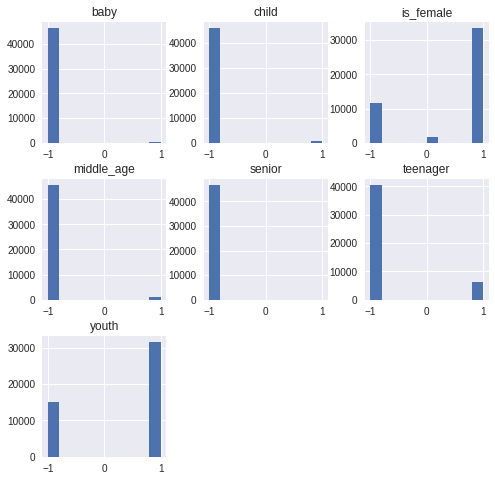

In [0]:
good_selfie_df.hist(figsize=(8,8))  


In [0]:
good_selfie_df.loc[good_selfie_df['baby']== -1, 'baby'] = 0
good_selfie_df.loc[good_selfie_df['teenager']== -1, 'teenager'] = 0
good_selfie_df[good_selfie_df.is_female != 0]
good_selfie_df.loc[good_selfie_df['is_female']== -1, 'is_female'] = 0
good_selfie_df.loc[good_selfie_df['child']== -1, 'child'] = 0
good_selfie_df.loc[good_selfie_df['youth']== -1, 'youth'] = 0
good_selfie_df.loc[good_selfie_df['middle_age']== -1, 'middle_age'] = 0
good_selfie_df.loc[good_selfie_df['senior']== -1, 'senior'] = 0
good_selfie_df.head(10)
good_selfie_df = good_selfie_df[:6000]



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Data Augmentation

In [0]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .95+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.
   
    A Random uniform distribution is used to generate different parameters for transformation
   
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape   
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
   
    # Brightness
  
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
       
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    img = augment_brightness_camera_images(img)
   
    return img

In [0]:
def augment(image_path, scale,row):
    num_files_desired = scale
    image = mpimg.imread(image_path)
    new_file_path = ("data")
    global good_selfie_df
    row1 = row
    for i in range(num_files_desired):
        img = transform_image(image,20,10,5)
        df = row1
        img_name =  " "
        img_name = row['image_name']
        print(row)
        print(row['image_name'])
        print("IMG NAME******************")
        print(img_name)
        print("IMG NAME******************")
        df['image_name']=img_name+'_'+str(i)
        good_selfie_df = good_selfie_df.append(df,ignore_index=True)
        cv2.imshow('img',img)
        cv2.imwrite(os.path.join(new_file_path , img_name+'_'+str(i)+'.jpg'), img)
        print(i)   

#### Augmenting skewed column

In [0]:
for index, row in good_selfie_df.iterrows():
    if row['baby'] == 1:
        image_id = row['image_name']
        image_path = 'Selfie-dataset/images/'+image_id+'.jpg'
        augment(image_path,100,row) 
    elif row['child'] == 1:
        image_id = row['image_name']
        image_path = 'Selfie-dataset/images/'+image_id+'.jpg'
        augment(image_path,20,row)
    elif row['middle_age'] == 1:
        image_id = row['image_name']
        image_path = 'Selfie-dataset/images/'+image_id+'.jpg'
        augment(image_path,10,row)
    elif row['senior'] == 1:
        image_id = row['image_name']
        image_path = 'Selfie-dataset/images/'+image_id+'.jpg'
        augment(image_path,1000,row)
    elif(row['teenager']==1): 
        image_id = row['image_name']
        image_path = 'Selfie-dataset/images/'+image_id+'.jpg'
        augment(image_path,3,row) 

image_name    01cdd7aa1a1a11e2aaa822000a1fb0dd_6
is_female                                      1
baby                                           0
child                                          0
teenager                                       1
youth                                          0
middle_age                                     0
senior                                         0
Name: 1, dtype: object
01cdd7aa1a1a11e2aaa822000a1fb0dd_6
IMG NAME******************
01cdd7aa1a1a11e2aaa822000a1fb0dd_6
IMG NAME******************


### Spilt the data

In [0]:
msk = np.random.rand(len(good_selfie_df)) < 0.85
train_df = good_selfie_df[msk]
test_df = good_selfie_df[~msk]

In [0]:
print(len(train_df))
print(len(test_df))

5121
879


In [0]:
imgs = []
y = []
for index, row in train_df.iterrows():
    file_name = row['image_name']
    y_val = [row['is_female'],row['baby'],row['child'],row['teenager'],row['youth'],row['middle_age'],row['senior']]
    image_path = 'Selfie-dataset/images/'+file_name+'.jpg'
    image = mpimg.imread(image_path)
    x = preprocess_input(image)
    imgs.append(x)
    y.append(y_val)

In [0]:
imgs_data = np.array(imgs)
y_data = np.array(y)
print(imgs_data.shape,y_data.shape)

(5121, 306, 306, 3) (5121, 7)


In [0]:
imgs = []
y = []
for index, row in test_df.iterrows():
    file_name = row['image_name']
    y_val = [row['is_female'],row['baby'],row['child'],row['teenager'],row['youth'],row['middle_age'],row['senior']]
    image_path = 'Selfie-dataset/images/'+file_name+'.jpg'
    image = mpimg.imread(image_path)
    x = preprocess_input(image)
    imgs.append(x)
    y.append(y_val)
imgs_test = np.array(imgs)
y_test = np.array(y)

In [0]:
import time

In [0]:
def create_model():
  num_classes = 7
  model = resnet50.ResNet50(weights='imagenet',include_top=False)
 # model.summary()
  last_layer = model.output
  # add a global spatial average pooling layer
  x = GlobalAveragePooling2D()(last_layer)
  # add fully-connected & dropout layers
  x = Dense(512, activation='relu',name='fc-1')(x)
  x = Dropout(0.5)(x)
  x = Dense(256, activation='relu',name='fc-2')(x)
  x = Dropout(0.5)(x)
  # a softmax layer for 4 classes
  out = Dense(num_classes, activation='softmax',name='output_layer_class')(x)
  # this is the model we will train
  custom_resnet_model2 = Model(inputs=model.input, outputs=out)
  custom_resnet_model2.summary()
  for layer in custom_resnet_model2.layers[:-6]:
    layer.trainable = False
  # custom_resnet_model2.layers[-1].trainable
  return custom_resnet_model2


In [0]:
def my_custom_loss(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    crossentropy = binary_crossentropy(y_true, y_pred)
    return mse + crossentropy

In [0]:
def train(custom_resnet_model2):
  
  custom_resnet_model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  ckpt_model = '/content/gdrive/My Drive/Colab Notebooks/Weights/weights.best.hdf5'
  checkpoint = ModelCheckpoint(filepath=ckpt_model,
                    monitor='val_acc',
                    verbose=1,
                    save_best_only=True,
                    mode='max')
  # fit the model
  t=time.time()  
  hist = custom_resnet_model2.fit(imgs_data, y_data, batch_size=32, epochs=12,verbose=1,callbacks=[checkpoint],validation_data=(imgs_test, y_test))
  print('Training time: %s' % (t - time.time()))
  (loss, accuracy) = custom_resnet_model2.evaluate(imgs_test, y_test, batch_size=10, verbose=1)
  print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

In [0]:
def train_with_load_weights(custom_resnet_model2):
  custom_resnet_model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  ckpt_model = '/content/gdrive/My Drive/Colab Notebooks/Weights/weights.best.hdf5'
  checkpoint = ModelCheckpoint(filepath=ckpt_model,
                    monitor='val_acc',
                    verbose=1,
                    save_best_only=True,
                    mode='max')
  # fit the model
  t=time.time()
  custom_resnet_model2.load_weights('/content/gdrive/My Drive/Colab Notebooks/Weights/weights.best.hdf5')
  hist = custom_resnet_model2.fit(imgs_data, y_data, batch_size=32, epochs=12,verbose=1,callbacks=[checkpoint],validation_data=(imgs_test, y_test))
  print('Training time: %s' % (t - time.time()))
  (loss, accuracy) = custom_resnet_model2.evaluate(imgs_test, y_test, batch_size=10, verbose=1)
  print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

In [0]:
def test_model(test_img):
  # create the model
  model = create_model()
  
  # load model weights
  model.load_weights('/content/gdrive/My Drive/Colab Notebooks/Weights/weights.best.hdf5')
  # predict values
  imag=[]
  image = mpimg.imread(test_img)
  image=preprocess_input(image)
  print(image.shape)
  imag.append(image)
  
  predicted_values = model.predict(np.array(imag))
  return predicted_values

In [0]:
model=create_model()
train(model)


In [0]:
test_model('/content/gdrive/My Drive/Colab Notebooks/15452982629764385963526153055975.jpg')

In [0]:
model=create_model()
train_with_load_weights(model)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
test_model('/content/gdrive/My Drive/Colab Notebooks/1545298894331556786724845911457.jpg')